In [2]:
import os
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
import seaborn as sns

# Linear Model Selection and Regulatrization

There are three different methods: 

***Subset Selection <br>
Shrinkage <br>
Dimenion Reduction***

In [188]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import r2_score

credit = pd.read_csv("Credit.csv")
credit["Student_numeric"] = credit["Student"].apply(lambda x: 1 if x == "Yes" else 0)

credit.head()

,Unnamed: 0,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance,Student_numeric
0,1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333,0
1,2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903,1
2,3,104.593,7075,514,4,71,11,Male,No,No,Asian,580,0
3,4,148.924,9504,681,3,36,11,Female,No,No,Asian,964,0
4,5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331,0


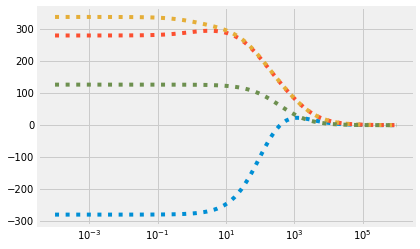

In [146]:
X = (credit.
    filter(["Income","Limit","Rating","Student_numeric"])
    )

scaler = np.zeros((2,len(X.columns))) # create array to store the mean and sd for each predictor
scaler[0,:] = np.mean(X, axis=0) # mean
scaler[1,:] = np.std(X, axis=0) # std
X_scale = (X - scaler[0,:])/scaler[1,:]

# or you can just use sklearn StandardScaler...
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

Y = credit.filter(["Balance"])

lambdas = np.logspace(-4,6,100)
#lambdas = np.linspace(0.001,1000000,100)
coeffs = np.zeros((len(X.columns),len(lambdas)))

i = 0
for lmda in lambdas:
    clf = Ridge(alpha = lmda)
    clf.fit(X_scaled,Y)
    coeffs[:,i] = clf.coef_
    i += 1

for row in coeffs:
    plt.plot(lambdas,row, linestyle=":")
plt.xscale("log")

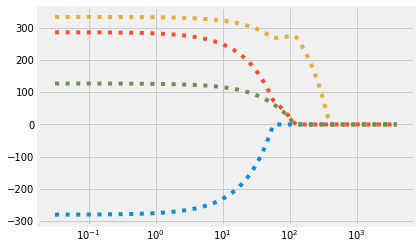

In [189]:
'''Now the same code but LASSO 
where the coefficient are becoming zero 
when the penalty term is high'''

X = (credit.
    filter(["Income","Limit","Rating","Student_numeric"])
    )

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Y = credit.filter(["Balance"])

lambdas = np.logspace(-1.5,3.6,100)
coeffs = np.zeros((len(X.columns),len(lambdas)))

i = 0
for lmda in lambdas:
    clf = Lasso(alpha = lmda)
    clf.fit(X_scaled,Y)
    coeffs[:,i] = clf.coef_
    i += 1

for row in coeffs:
    plt.plot(lambdas,row, linestyle=":")
plt.xscale("log")

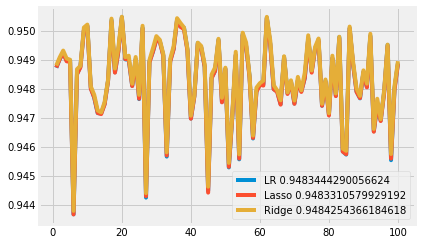

In [244]:
''' So what's the best? '''
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score



lr = LinearRegression()
lasso = Lasso(alpha=.5) # alpha default 1.0
rr = Ridge(alpha=.5) #alpha default 1.0


iterations = 100

lr_mse_avg = []    
lasso_mse_avg = []
rr_mse_avg = []

seed = 1
for iteration in range(iterations):
    
    lr_mse = []
    lasso_mse = []
    rr_mse = []
    
    kfold = KFold(n_splits = 10, random_state = seed, shuffle=True)

    for train_index, test_index in kfold.split(X_scaled):
        X_train, X_test, y_train, y_test = X_scaled[train_index], X_scaled[test_index], Y[train_index], Y[test_index]
    
        lr.fit(X_train,y_train)
        lr_y = lr.predict(X_test)
        lr_mse.append(r2_score(y_test,lr_y))
    
        lasso.fit(X_train,y_train)
        lasso_y = lasso.predict(X_test)
        lasso_mse.append(r2_score(y_test,lasso_y))
    
        rr.fit(X_train,y_train)
        rr_y = rr.predict(X_test)
        rr_mse.append(r2_score(y_test,rr_y))
    
    lr_mse_avg.append(np.mean(lr_mse))
    lasso_mse_avg.append(np.mean(lasso_mse))
    rr_mse_avg.append(np.mean(rr_mse))
    
    seed += 1
    
fig, ax = plt.subplots()

ax.plot(range(1,iterations+1),lr_mse_avg)
ax.plot(range(1,iterations+1),lasso_mse_avg)
ax.plot(range(1,iterations+1),rr_mse_avg)
ax.legend(labels=["LR "+str(np.mean(lr_mse_avg)),
                  "Lasso "+str(np.mean(lasso_mse_avg)),
                  "Ridge "+str(np.mean(rr_mse_avg))])

### Dimension reduction

In [254]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

X = (credit.
    filter(["Income","Limit","Rating","Student_numeric"])
    )

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Y = credit.filter(["Balance"])
Y = Y.values

iterations = 100
pca_mse_avg = []    
seed = 1

lr = LinearRegression()
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

for iteration in range(iterations):
    pca_mse = []
    kfold = KFold(n_splits = 10, random_state = seed, shuffle=True)

    for train_index, test_index in kfold.split(X_scaled):
        X_train, X_test, y_train, y_test = X_pca[train_index], X_pca[test_index], Y[train_index], Y[test_index]
    
        lr.fit(X_train,y_train)
        lr_y = lr.predict(X_test)
        pca_mse.append(r2_score(y_test,lr_y))
    
    pca_mse_avg.append(np.mean(pca_mse))
    seed += 1
    
print("R^2 score is {0:.4%}, which is a increase of 0.2%".format(np.mean(pca_mse_avg)))

R^2 score is 94.8611%, which is a increase of 0.2%


In [256]:
from sklearn.cross_decomposition import PLSRegression

iterations = 100
pls_mse_avg = []    
seed = 1

pls = PLSRegression(n_components=3)

for iteration in range(iterations):
    pls_mse = []
    kfold = KFold(n_splits = 10, random_state = seed, shuffle=True)

    for train_index, test_index in kfold.split(X_scaled):
        X_train, X_test, y_train, y_test = X_scaled[train_index], X_scaled[test_index], Y[train_index], Y[test_index]
    
        pls.fit(X_train,y_train)
        pls_y = pls.predict(X_test)
        pls_mse.append(r2_score(y_test,pls_y))
    
    pls_mse_avg.append(np.mean(pls_mse))
    seed += 1
    
print("R^2 score is {0:.4%}, which is a increase of 0.2%".format(np.mean(pls_mse_avg)))


R^2 score is 94.8608%, which is a increase of 0.2%
